# 02 · Codificación offline a HDF5

Este notebook convierte un split CSV (`train/val/test`) a un __HDF5__ con codificación __rate/latency/raw__ para acelerar entrenamientos (evita encode on-the-fly).

__Cómo encaja en el TFM__: permite __benchmarks__ consistentes y comparables de entrenamiento, con tiempos más estables.

__Parámetros y rutas__

Definimos qué split convertir y con qué __encoder__. La ruta de salida incluye `T/GAIN/SIZE` para trazabilidad.

In [1]:
# imports & params

from pathlib import Path
import sys, pandas as pd

ROOT = Path.cwd().parents[0] if (Path.cwd().name == "notebooks") else Path.cwd()
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

from src.prep.encode_offline import encode_csv_to_h5

RUN     = "circuito1"
SPLIT   = "train"              # "train" | "val" | "test"
ENCODER = "rate"               # "rate" | "latency" | "raw"
T       = 20
GAIN    = 0.5                  # solo aplica a 'rate'
SIZE    = (160, 80)            # (W, H)
TO_GRAY = True                 # convertir a escala de grises
SEED    = 42

RAW  = ROOT/'data'/'raw'/'udacity'
PROC = ROOT/'data'/'processed'

CSV  = PROC/RUN/f"{SPLIT}.csv"
BASE = RAW/RUN

# Nombre auto-descriptivo del fichero de salida
suffix_gain = f"gain{GAIN}" if ENCODER == "rate" else "gain0"
OUT  = PROC/RUN/f"{SPLIT}_{ENCODER}_T{T}_{suffix_gain}_{'gray' if TO_GRAY else 'rgb'}_{SIZE[0]}x{SIZE[1]}.h5"

# Comprobaciones rápidas
assert CSV.exists(), f"No existe CSV: {CSV}"
assert BASE.exists(), f"No existe base dir de imágenes: {BASE}"
OUT

PosixPath('/home/cesar/proyectos/TFM_SNN/data/processed/circuito1/train_rate_T20_gain0.5_gray_160x80.h5')

__Ejecutar codificación__

Llamamos a `encode_csv_to_h5`. Si el fichero existe, se sobreescribe.

In [2]:
encode_csv_to_h5(
    csv_df_or_path=CSV,
    base_dir=BASE,
    out_path=OUT,
    encoder=ENCODER,
    T=T,
    gain=GAIN,
    size_wh=SIZE,
    to_gray=TO_GRAY,
    seed=SEED,
)
print("Guardado:", OUT)

Guardado: /home/cesar/proyectos/TFM_SNN/data/processed/circuito1/train_rate_T20_gain0.5_gray_160x80.h5


__Inspección rápida del HDF5 (opcional)__

Abrimos el `.h5` generado para:

- listar atributos del fichero (`T`, `gain`, `size`, etc.),
- revisar la estructura (grupo samples, `steering`, …),
- comprobar formas y dtypes,
- y visualizar una proyección simple (acumulado temporal) del primer ejemplo para verificar que los datos tienen sentido.

Atributos del H5:
 - T: 20
 - encoder: rate
 - gain: 0.5
 - size_wh: [160  80]
 - to_gray: 1

Top-level keys: ['spikes', 'steering']

Formato 'spikes' detectado.
spikes shape: (10468, 20, 1, 80, 160) | dtype: uint8
steering shape: (10468,) | dtype: float32 | rango: (-1.0, 1.0)
sample[0] (post-index) shape: (20, 1, 80, 160) | dtype: uint8


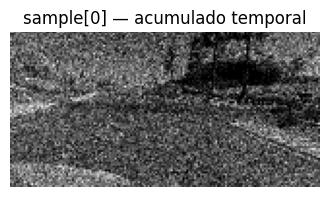

In [ ]:
# Inspección del H5 (formato oficial)
import h5py, numpy as np, matplotlib.pyplot as plt

def _proj_img(x):
    # (T,H,W) -> acumula T; (T,C,H,W) -> acumula T y C
    if x.ndim == 2:       # (H,W)
        return x
    if x.ndim == 3:       # (T,H,W)
        return x.sum(axis=0)
    if x.ndim == 4:       # (T,C,H,W)
        return x.sum(axis=(0,1))
    raise ValueError(x.shape)

with h5py.File(OUT, "r") as h5:
    print("Atributos:")
    for k in h5.attrs:
        print(f" - {k}: {h5.attrs[k]}")
    print("Datasets:", list(h5.keys()))

    X = h5["spikes"]
    y = h5["steering"]
    print("spikes:", X.shape, X.dtype, "| steering:", y.shape, y.dtype)

    # primera muestra
    x0 = X[0]               # (T,H,W) o (T,C,H,W)
    acc = _proj_img(x0)
    plt.figure(figsize=(4,3))
    plt.imshow(acc, cmap="gray")
    plt.title("sample[0] — acumulado temporal")
    plt.axis("off")
    plt.show()
